In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('MBB.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
df

,Price
0,11783.9
1,12267.4
2,12267.4
3,12307.6
4,12448.7
...,...
1237,18850.0
1238,18800.0
1239,18450.0
1240,18600.0


In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8233.109, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8245.783, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8247.797, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8247.785, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8243.786, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8244.939, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8245.753, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8235.100, Time=1.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8235.056, Time=0.96 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8247.847, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8246.318, Time=1.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8247.606, Time=0.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8236.156, Time=1.84 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=8231.107, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0]          

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val = model.predict(n_periods=len(y_val))

In [6]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[12033.84522443 12059.29844045 12051.18031828 12027.33873874
 12029.57063212 12050.81068833 12053.18196134 12035.14567703
 12029.412293   12043.97198325 12051.93000472 12040.85357213
 12031.66398015 12039.45319188 12049.04838911 12044.20760039
 12034.85805765 12037.17817833 12045.80120584 12045.53107503
 12037.9581358  12036.65440814 12042.99192653 12045.41672503
 12040.38417903 12037.2472118  12040.9972582  12044.49445832
 12041.93578558 12038.36666787]


In [7]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 7584.791201983608
Testing RMSE: 10821.080657792196
Validation MAPE: 36.814830176842186
Testing MAPE: 42.33118280373034
Validation MAE: 7258.0003915127745
Testing MAE: 9897.824026603177


Validation RMSE: 7584.791201983608
Testing RMSE: 10821.080657792196


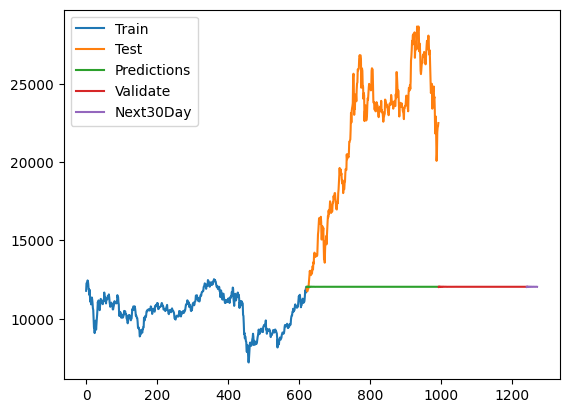

In [8]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()